In [ ]:
# 구글 번역 api (처음 한번만 설치)
%pip install googletrans==4.0.0-rc1

In [39]:
# 이 파일 있는 디렉터리로 이동??
import os
os.chdir(os.getcwd())
%pwd

#%cd /content/drive/MyDrive/Github/floread/sentiment-analysis

'c:\\Users\\KangIW\\git_j500\\floread'

In [9]:
# 가장 퀄리티가 나은 감성대화말뭉치 사용
import pandas as pd

df = pd.read_csv('data/감성대화말뭉치(병합).csv',index_col=0)
df.shape

(58240, 2)

In [11]:
df['emotion'] = df['emotion'].replace('상처', '슬픔')
df.groupby('emotion').count().iloc[:,0]

emotion
기쁨     7337
당황     9797
분노    10414
불안    10429
슬픔    20263
Name: sentence, dtype: int64

In [8]:
import re

#한글 있는지 체크
def has_korean(text):
    korean_check = lambda text: any(char >= '가' and char <= '힣' for char in text)
    return korean_check(text)

#0으로 끝나는 문장
def remove_end_0(sentence):
    if sentence.endswith('0'):
        return sentence[:-1]
    return sentence

def Preprocess_all(df):
    
    print("---------------전처리 전: ",df.shape)
    
    # 결측치 제거
    df = df.dropna()
    
    #필터 처리된 단어 공백으로 치환
    df['sentence'] = df['sentence'].str.replace(r'OO+', ' ', regex=True)
    
    #좌측 공백 제거
    df['sentence'] = df['sentence'].str.lstrip()
    
    #한글 없는 문장 제거
    df = df[df['sentence'].apply(lambda x: has_korean(x))]
    
    #한자 들어간 문장 제거
    df = df[~df['sentence'].str.contains('[\u4e00-\u9fff]')]
        
    #일부 단어 치환
    df['sentence'] = df['sentence'].str.replace(r'(ㅋ{3,})', 'ㅋㅋ', regex=True)
    df['sentence'] = df['sentence'].str.replace(r'\?\?{3,}', '??,', regex=True)
    df['sentence'] = df['sentence'].str.replace(r'~{3,}', '~~', regex=True)
    df['sentence'] = df['sentence'].str.replace(r'!{3,}', '!!', regex=True)
    df['sentence'] = df['sentence'].str.replace(r'-{3,}', '--', regex=True)
    df['sentence'] = df['sentence'].str.replace(r'(ㅠ{3,})', 'ㅠㅠ', regex=True)
    df['sentence'] = df['sentence'].str.replace(r'(ㅜ{3,})', 'ㅜㅜ', regex=True)
    df['sentence'] = df['sentence'].str.replace(r'(ㄱ{3,})', 'ㄱㄱ', regex=True)
    df['sentence'] = df['sentence'].str.replace(r'(ㄷ{3,})', 'ㄷㄷ', regex=True)
    df['sentence'] = df['sentence'].str.replace(r'(ㅎ{3,})', 'ㅎㅎ', regex=True)

    df['sentence'] = df['sentence'].str.replace(r'(♥{2,})', '♥', regex=True)
    df['sentence'] = df['sentence'].str.replace(r'(♡{2,})', '♡', regex=True)
    df['sentence'] = df['sentence'].str.replace(r'\s{2,}', ' ', regex=True)
    
    df['sentence'] = df['sentence'].str.replace(r'\.{7,}', '......', regex=True)
    df['sentence'] = df['sentence'].str.replace(';{3,}', ';;')
    df['sentence'] = df['sentence'].str.replace('\^{3,}', '^^')
    
    # 한글 자모음이 3번 이상 반복되는 패턴을 찾아, 그 자모음 2개로 치환
    df['sentence'] = df['sentence'].apply(lambda x: re.sub(r'(([ㄱ-ㅎㅏ-ㅣ]|ㄲ|ㄸ|ㅃ|ㅆ|ㅉ){3,})', lambda m: m.group(1)[:2], x))

    # 길이가 100이상인 문장 제거
    df = df[df['sentence'].str.len() < 100]
    
    # 0으로 끝나면 0빼기
    df['sentence'] = df['sentence'].apply(remove_end_0)
    
    #의미 없는 0패턴 제거
    replacements = {
        r'\?0': '?',
        r';0': ';',
        r'ㅠ0': 'ㅠ',
        r'ㅜ0': 'ㅜ',
        r'\.0': '.'
    }

    for pattern, replacement in replacements.items():
        df['sentence'] = df['sentence'].str.replace(pattern, replacement, regex=True)
        
    # 중복행 제거
    dup = df[df.duplicated(subset=['sentence'])]
    print("중복되는 행: ", len(dup))
    df = df.drop_duplicates(subset=['sentence'], keep='first')
    
    # 인덱스 재설정
    df.reset_index(drop=True, inplace=True)

    print("---------------전처리 후: ",df.shape)    
    
    return df

In [16]:
pp_df = Preprocess_all(df)

---------------전처리 전:  (58240, 2)
중복되는 행:  0
---------------전처리 후:  (58224, 2)


In [ ]:
pp_df.to_csv('data/감성대화말뭉치_전처리완.csv', encoding='utf-8-sig')

In [2]:
import pandas as pd
df = pd.read_csv('data/감성대화말뭉치_전처리완.csv',index_col=0)
df.groupby('emotion').count().iloc[:,0]

emotion
기쁨     7334
당황     9794
분노    10410
불안    10428
슬픔    20258
Name: sentence, dtype: int64

In [28]:
dfsum = pd.read_csv('data/병합데이터셋-v3.csv',index_col=0)
print(dfsum.shape)
dfsum.groupby('emotion').count().iloc[:,0]

(135791, 2)


emotion
놀람    19538
분노    19526
불안    15980
슬픔    21305
중립    45149
행복    14293
Name: sentence, dtype: int64

놀람1000,분노1000, 불안4000, 슬픔 -, 중립-, 행복6000

In [3]:
import pandas as pd
df = pd.read_csv('data/감성대화말뭉치_전처리완.csv',index_col=0)
df = df[df['emotion'] != '슬픔']
df.shape

(37966, 2)

In [4]:
from googletrans import Translator
import time

# 전역으로 선언하면 오버해드가 줄어든다?
translator = Translator()

# 역번역 함수: 한글 -> 영어 -> 한글
def backtranslate(text):
    global translator   
    
    en = translator.translate(text, src='ko', dest='en').text
    time.sleep(0.3)   #ReadTimeout 방지
    
    kr = translator.translate(en, src='en', dest='ko').text
    time.sleep(0.3)   
    
    return kr

In [4]:
# 카운트 테스트
from googletrans import Translator
import time

translator = Translator()

cnt=0
# 역번역 함수: 한글 -> 영어 -> 한글
def backtranslate(text):
    global translator   
    global cnt
    
    cnt +=1
    if cnt%100 ==0: print(cnt)
    en = translator.translate(text, src='ko', dest='en').text
    time.sleep(0.5)   #ReadTimeout 방지
    
    kr = translator.translate(en, src='en', dest='ko').text
    time.sleep(0.5)   
    
    return kr

In [5]:
# (에러방지)데이터 프레임 분리 후 각각 번역
df1 = df[:3000]
df2 = df[3000:6000]
df3 = df[6000:9000]
df4 = df[9000:12000]
df5 = df[12000:15000]
df6 = df[15000:18000]
df7 = df[18000:21000]
df8 = df[21000:24000]
df9 = df[24000:27000]
df10 = df[27000:30000]
df11 = df[30000:33000]
df12 = df[33000:36000]
df13 = df[36000:]

In [ ]:
df1['sentence'] = df1['sentence'].apply(backtranslate)
df1.to_csv('res/df1.csv', encoding='utf-8-sig')

In [26]:
import pandas as pd

df1 = pd.read_csv('data/df1.csv',index_col=0)
df2 = pd.read_csv('data/df2.csv',index_col=0)
df3 = pd.read_csv('data/df3.csv',index_col=0)
df4 = pd.read_csv('data/df4.csv',index_col=0)
df5 = pd.read_csv('data/df5.csv',index_col=0)
df6 = pd.read_csv('data/df6.csv',index_col=0)
df7 = pd.read_csv('data/df7.csv',index_col=0)
df8 = pd.read_csv('data/df8.csv',index_col=0)
df9 = pd.read_csv('data/df9.csv',index_col=0)
df10 = pd.read_csv('data/df10.csv',index_col=0)
df11 = pd.read_csv('data/df11.csv',index_col=0)
df12 = pd.read_csv('data/df12.csv',index_col=0)
df13 = pd.read_csv('data/df13.csv',index_col=0)

concat_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13])
concat_df.shape

(37966, 2)

In [27]:
concat_df['emotion'].replace({'당황': '놀람', '기쁨': '행복'}, inplace=True)

In [28]:
# 번역과정에서 불필요하게 영어가 남아 있는 경우가 너무 많아 모두 삭제해줬음
print("원래 길이: ", len(concat_df))

# 영어를 포함하는 행을 필터링
english_rows = concat_df['sentence'].str.contains(r'[a-zA-Z]', regex=True)

# 영어를 포함하는 행을 삭제
concat_df = concat_df[~english_rows]

print("영어 포함 문장 삭제 후: ", len(concat_df))

원래 길이:  37966
영어 포함 문장 삭제 후:  37367


In [29]:
concat_df.groupby('emotion').count().iloc[:,0]

emotion
놀람     9649
분노    10275
불안    10275
행복     7168
Name: sentence, dtype: int64

In [30]:
filtered_df = Preprocess_all(concat_df)

---------------전처리 전:  (37367, 2)
중복되는 행:  809
---------------전처리 후:  (36550, 2)


In [31]:
# 이중에서 놀람1000, 분노1000, 불안4000, 행복6000 추출


# 각 감정에 따라 랜덤하게 행을 추출
surprise_rows = filtered_df[filtered_df['emotion'] == '놀람'].sample(1000, replace=True)
happy_rows = filtered_df[filtered_df['emotion'] == '행복']   #전처리 처리 결과 6000개만 샘플하면 행복태그가 부족함
angry_rows = filtered_df[filtered_df['emotion'] == '분노'].sample(1000, replace=True)
fear_rows = filtered_df[filtered_df['emotion'] == '불안'].sample(4000, replace=True)

# 추출된 행들을 합치기
sampled_df = pd.concat([surprise_rows, happy_rows, angry_rows, fear_rows]).reset_index(drop=True)

In [32]:
dfv3 = pd.read_csv('data/병합데이터셋-v3.csv',index_col=0)

concated_df = pd.concat([sampled_df, dfv3])
concated_df.shape

(148778, 2)

In [33]:
dfv5 = Preprocess_all(concated_df)

---------------전처리 전:  (148778, 2)
중복되는 행:  868
---------------전처리 후:  (147910, 2)


In [34]:
dfv5.groupby('emotion').count().iloc[:,0]

emotion
놀람    20477
분노    20473
불안    19258
슬픔    21299
중립    45141
행복    21262
Name: sentence, dtype: int64

In [35]:
dfv5.to_csv('data/병합데이터셋-v5.csv', encoding='utf-8-sig')

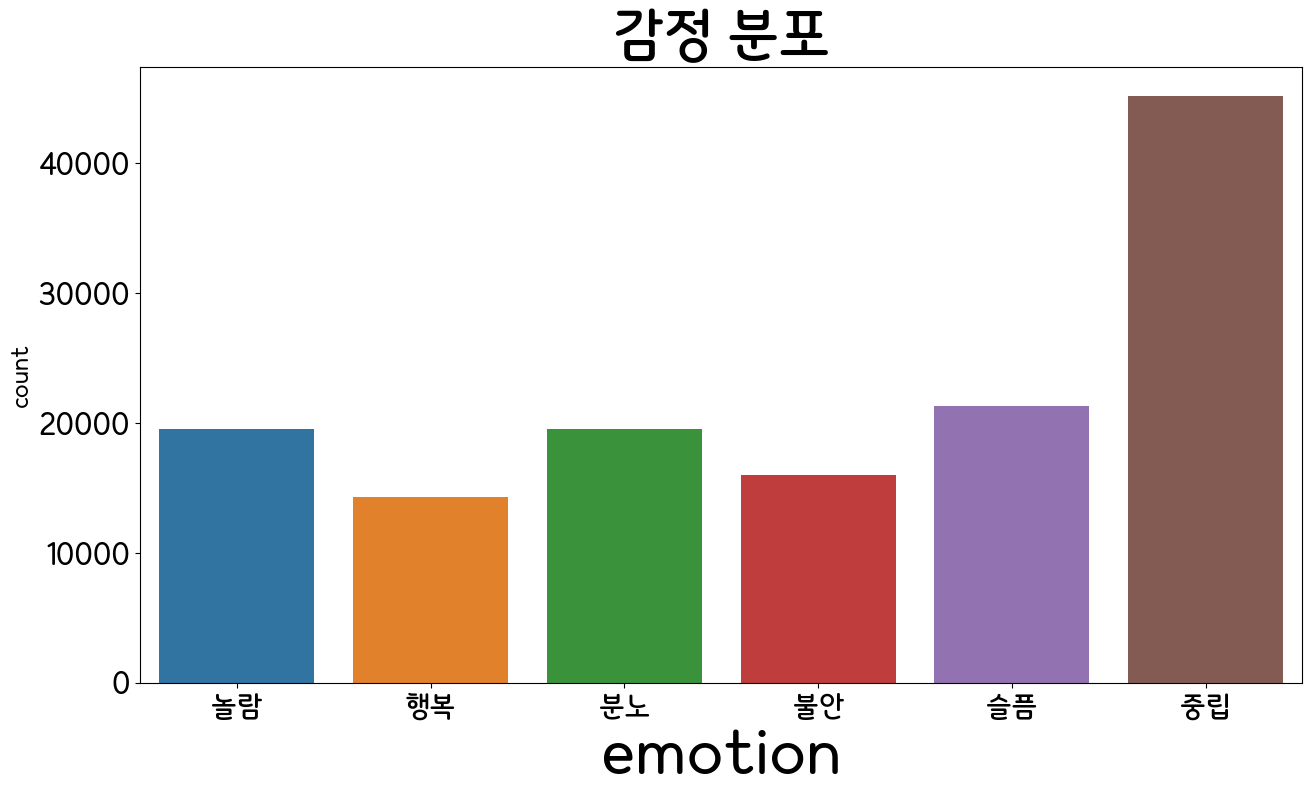

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import pandas as pd

dfv3 = pd.read_csv('data/병합데이터셋-v3.csv', index_col=0)

# (한글 출력하려고) 폰트 변경
fontpath = 'NPSfont_regular.ttf'
font_name = fm.FontProperties(fname=fontpath).get_name()
plt.rc('font', family=font_name)

# 원하는 순서대로 정렬
emotion_order = ['놀람', '행복', '분노', '불안', '슬픔', '중립']

# countplot으로 시각화
plt.figure(figsize=(15, 8))  # figsize를 plt.rcParams 대신 직접 설정
sns.countplot(x='emotion', data=dfv3, order=emotion_order)
plt.title('감정 분포', fontsize=40)
plt.xlabel('emotion', fontsize=40)
plt.ylabel('count', fontsize=15)
plt.show()

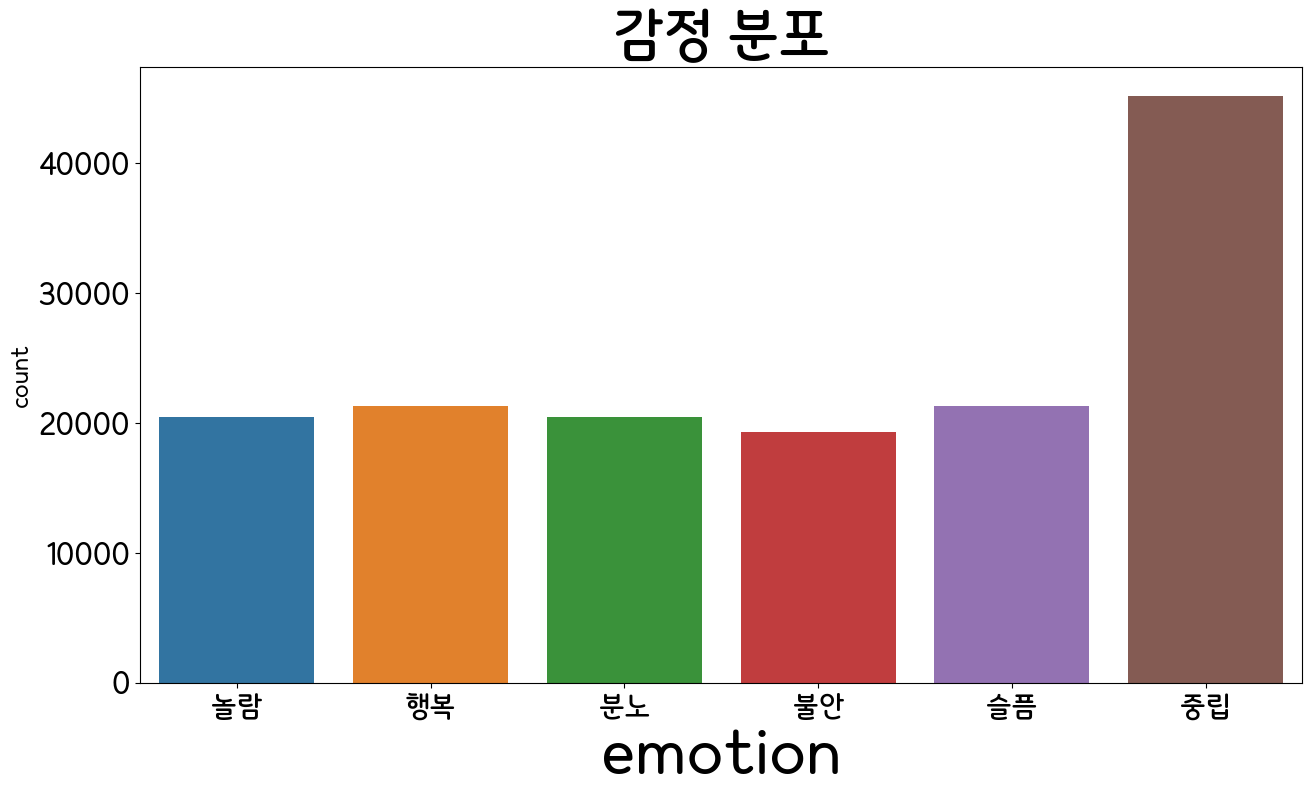

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import pandas as pd

dfv3 = pd.read_csv('data/병합데이터셋-v5.csv', index_col=0)

# (한글 출력하려고) 폰트 변경
fontpath = 'NPSfont_regular.ttf'
font_name = fm.FontProperties(fname=fontpath).get_name()
plt.rc('font', family=font_name)

# 원하는 순서대로 정렬
emotion_order = ['놀람', '행복', '분노', '불안', '슬픔', '중립']

# countplot으로 시각화
plt.figure(figsize=(15, 8))  # figsize를 plt.rcParams 대신 직접 설정
sns.countplot(x='emotion', data=dfv3, order=emotion_order)
plt.title('감정 분포', fontsize=40)
plt.xlabel('emotion', fontsize=40)
plt.ylabel('count', fontsize=15)
plt.show()